[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-1-mg-basics/8-multigrid-v-cycle.ipynb)

In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

### Define:

- `hnorm`: a grid dependent L2 norm
- `poissonopmatrix` and `poissonop`, a matrix and matrix free version of the Poisson operator
- `residual`, `relax`, `interpolate`, `restrict`, matrix free multigrid components

In [2]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

def poissonopmatrix(n):
    A = (n+1)**2 * sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')
    return A

def poissonop(u):
    """
    Poisson operator h^{-2} * [-1 2 1]
    Action of A * u
    """
    n = len(u)
    v = np.zeros(len(u))
    v[1:-1] = ((n+1)**2) * (2 * u[1:-1] - u[2:] - u[:-2])
    v[0]    = ((n+1)**2) * (2 * u[0]    - u[1])
    v[-1]   = ((n+1)**2) * (2 * u[-1]   - u[-2])
    return v

def residual(u, f):
    """
    f - A u
    """
    n = len(f)
    r = np.zeros(len(u))
    r[1:-1] = f[1:-1] - ((n+1)**2) * (2 * u[1:-1] - u[2:] - u[:-2])
    r[0]    = f[0]    - ((n+1)**2) * (2 * u[0]    - u[1])
    r[-1]   = f[-1]   - ((n+1)**2) * (2 * u[-1]   - u[-2])
    return r

def relax(u, f, nu):
    """
    Weighted Jacobi
    """
    n = len(u)
    Dinv = 1.0 / (2.0 * ((n+1)**2))
    omega = 2.0 / 3.0
    unew = u.copy()
    
    for steps in range(nu):
        unew = unew + omega * Dinv * residual(unew, f)
    
    return unew

def interpolate(uc):
    """interpolate u of size 2**(k-1)-1 to 2**(k)-1"""
    uf = np.zeros((2*len(uc) + 1,))
    uf[:-1:2] = 0.5 * uc
    uf[1::2] = uc
    uf[2::2] += 0.5 * uc
    return uf

def restrict(uf):
    """restrict u of size 2**(k)-1 to 2**(k-1)-1"""
    uc = 0.25 * uf[:-1:2] + 0.5 * uf[1::2] + 0.25 * uf[2::2]
    return uc

### Two-grid, hand-coded

In [3]:
def vcycle2(u0, f0, nu):
    u0 = relax(u0, f0, nu)
    f1 = restrict(residual(u0, f0))
    u1 = sla.spsolve(poissonopmatrix(len(f1)), f1)    
    ui = interpolate(u1)
    u0 = u0 + ui
    u0 = relax(u0, f0, nu)
    return u0

### Three-grid, hand-coded

In [4]:
def vcycle3(u, f, nu):
    f0 = f.copy()
    u0 = u.copy()
    
    u0 = relax(u0, f0, nu)
    f1 = restrict(residual(u0, f0))
    
    u1 = relax(np.zeros(len(f1)), f1, nu)
    f2 = restrict(residual(u1, f1))
    
    A2 = poissonopmatrix(len(f2))
    u2 = sla.spsolve(A2, f2)
    
    u1 += interpolate(u2)
    u1 = relax(u1, f1, 1)
    
    u0 += interpolate(u1)
    u0 = relax(u0, f0, 1)
    return u0

### V-cycle (non-recursive)

In [5]:
def vcycle(kmax, kmin, u, f, nu):
    """
    kmax : size of the fine grid 2**kmax -1
    kmin : size of the coarse grid 2**kmin - 1
    """
    ulist = [None for k in range(kmax+1)]
    flist = [None for k in range(kmax+1)]
    
    # down cycle
    for k in range(kmax, kmin, -1):
        u = relax(u, f, nu)
        ulist[k] = u
        flist[k] = f
        
        f = restrict(residual(u, f))
        u = np.zeros(f.shape)
        ulist[k-1] = u
        flist[k-1] = f

    # coarsest grid
    Ac = poissonopmatrix(2**kmin - 1)
    flist[kmin] = f
    ulist[kmin] = sla.spsolve(Ac, f)

    # up cycle
    for k in range(kmin+1, kmax+1, 1):
        u = ulist[k]
        f = flist[k]
        uc = ulist[k-1]
        u += interpolate(uc)
        u = relax(u, f, nu)
    return u

## Set up a problem

Here we will set up a problem on $\Omega = [0,1]$.
$$
f = 2 - 12 x^2\\
u^* = x^4 - x^2
$$
where $u^*$ will solve the problem
$$
-u'' = f
$$
In addition, from the matrix problem $A u = f$, we define
$$
u^*_d = A^{-1} f
$$

In [6]:
kmax = 5
kmin = 2

# set up fine problem
n = 2**kmax - 1

xx = np.linspace(0, 1, n+2)[1:-1]

f = 2 - 12 * xx**2

ustar = xx**4 - xx**2
A = poissonopmatrix(len(f))
udstar = sla.spsolve(A, f)
print("discretization error: ", hnorm(ustar - udstar))

discretization error:  3.1518404129513896e-05


## Things to measure

We'll measure four things in this test:
1. The residual
$$
r_k = f - A u_k
$$
2. The discretization error
$$
e = u^* - u_d^*
$$
3. The total error
$$
e = u^* - u_k
$$
4. The algebraic error
$$
e = u^*_d - u_k
$$

In [13]:
u = np.random.rand(len(f))

# set up smoothing sweeps
nu = 1

res = []
err = []
aerr = []

res.append(hnorm(residual(u, f)))
for i in range(15):
    u = vcycle(kmax, kmin, u, f, nu)
    res.append(hnorm(residual(u, f)))
    err.append(hnorm(u - ustar))
    aerr.append(hnorm(udstar - u))
    print("res = %10.4e, total err = %10.4e  alg err = %10.4e" % (res[-1], err[-1], aerr[-1]))

res = 8.9979e+00, total err = 1.6449e-02  alg err = 1.6446e-02
res = 1.8224e+00, total err = 4.4571e-03  alg err = 4.4570e-03
res = 4.9326e-01, total err = 1.2451e-03  alg err = 1.2453e-03
res = 1.4055e-01, total err = 3.4703e-04  alg err = 3.4631e-04
res = 3.9727e-02, total err = 9.9917e-05  alg err = 9.5531e-05
res = 1.1079e-02, total err = 4.0553e-05  alg err = 2.6192e-05
res = 3.0595e-03, total err = 3.2186e-05  alg err = 7.1542e-06
res = 8.3981e-04, total err = 3.1545e-05  alg err = 1.9500e-06
res = 2.2977e-04, total err = 3.1515e-05  alg err = 5.3099e-07
res = 6.2773e-05, total err = 3.1517e-05  alg err = 1.4455e-07
res = 1.7143e-05, total err = 3.1518e-05  alg err = 3.9360e-08
res = 4.6829e-06, total err = 3.1518e-05  alg err = 1.0724e-08
res = 1.2802e-06, total err = 3.1518e-05  alg err = 2.9243e-09
res = 3.5033e-07, total err = 3.1518e-05  alg err = 7.9843e-10
res = 9.5990e-08, total err = 3.1518e-05  alg err = 2.1836e-10


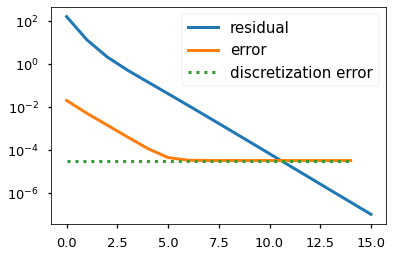

In [10]:
plt.semilogy(res, lw=3, label='residual')
plt.semilogy(err, lw=3, label='error')
de = hnorm(ustar - udstar)
plt.semilogy([de for i in range(len(err))],':', lw=3, label='discretization error')
plt.legend(fontsize=15)

In [9]:
res

[164.72478521566904,
 13.600674993987809,
 2.158469257603809,
 0.5223593040229846,
 0.14631842947286164,
 0.04153847584675892,
 0.011647470430006145,
 0.003224042032042035,
 0.0008841942165242901,
 0.00024108608351483378,
 6.551983903653123e-05,
 1.7778977780877564e-05,
 4.822921960619987e-06,
 1.3092060998197664e-06,
 3.559618558025253e-07,
 9.704100195261439e-08]